In [1]:
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract2D(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

   #defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

### When changing this for different targets or
### changing between RED and BLUE sides
## use separate notebooks!
### this template is designed for one at a time, otherwise there will be naming problems

# Subtracting Instrumentation Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
flatid = 'DomeFlat'
atlasfiles_red = fits.open('henear.fits') #NOAO atlas  #RED side 
atlasfiles_blue = fits.open('fear.fits') #NOAO atlas #BLUE side 
linelist_red = reduce_dblspec.HENEAR_LINE_LIST #RED side
linelist_blue = reduce_dblspec.FEAR_LINE_LIST #BLUE side

############### possible changes to change targets
##################################################
arcfiles_red10 = 'DoubleSpec/20170518/red0012.fits' #ARC lamp #1.0" slit #RED side
arcfiles_blue10 = 'DoubleSpec/20170518/blue0012.fits' #ARC lamp #1.0" slit #BLUE side
targetID = '79005021831220-Catch22'
all_side_files_red = 'DoubleSpec/20170518/red*.fits'#RED side
all_side_files_blue = 'DoubleSpec/20170518/blue*.fits'#BLUE side
#target = fits.open('DoubleSpec/20170518/red0079.fits') #use these to get targetid
#target[0].header
##################################################

# Creating a RED Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


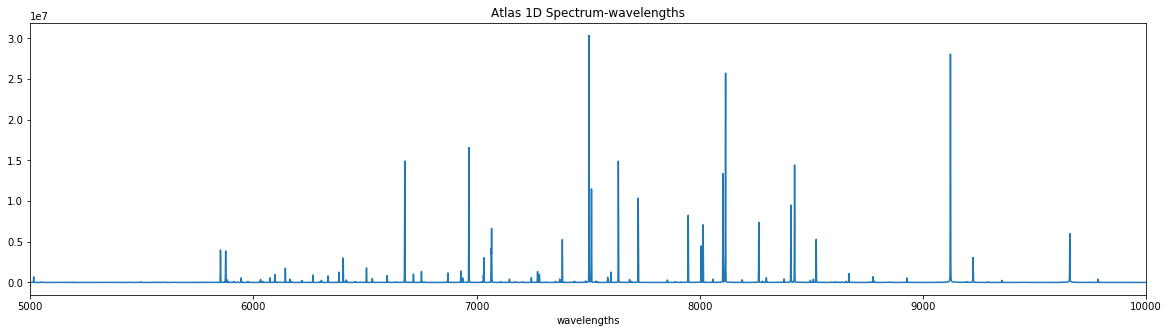

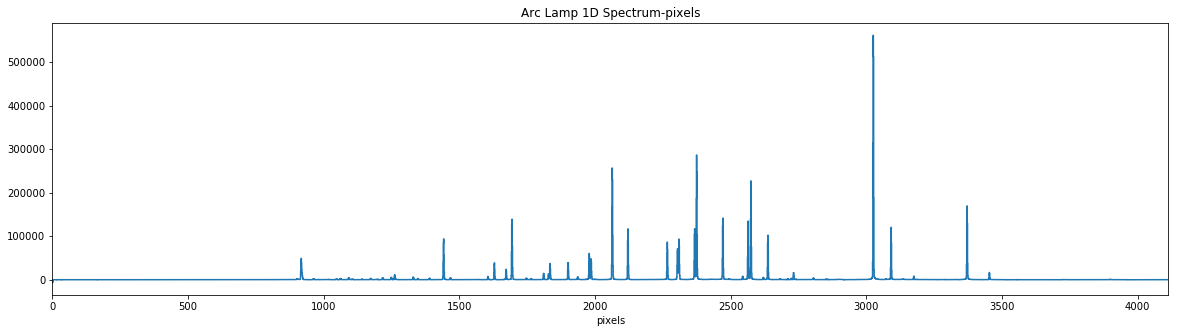

In [4]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_red = pipeline.dispersion(all_side_files_red, atlasfiles_red, arcfiles_red10, linelist_red,flatid)

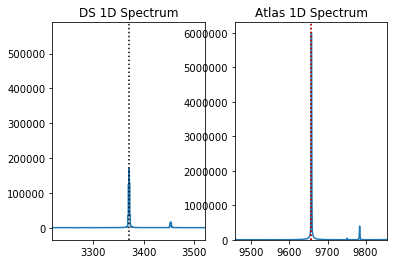

In [5]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(3370,9657,specset_red) #(arc-PIX-guess, atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [3024,2373,2062,1672,3370]
atlas_lines = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 6.71869024521498, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 7.395561544387761, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Tried to find peak at 2338.0234170166977 but it's in a valley, not a peak"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Guessed line's peak to base ratio is 0.9423511275390428, which is less than 10"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 0.9588258798377841, which is less than 10"
Failed to find line NeI at wl=8377.6065: "Guessed line's peak to base ratio is 9.895947290981596, which is less than 10"
Found line ArI at wl=8408.2096
Clipped 0 lines
Found line ArI at wl=8424.6475
Clipped 0 li

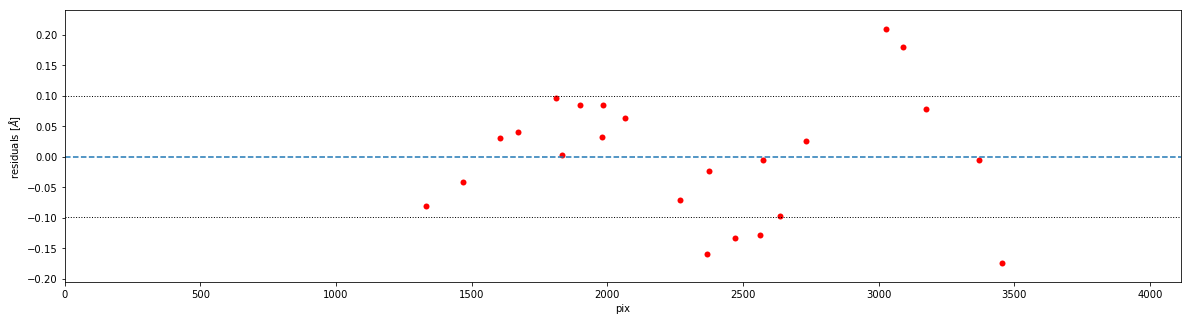

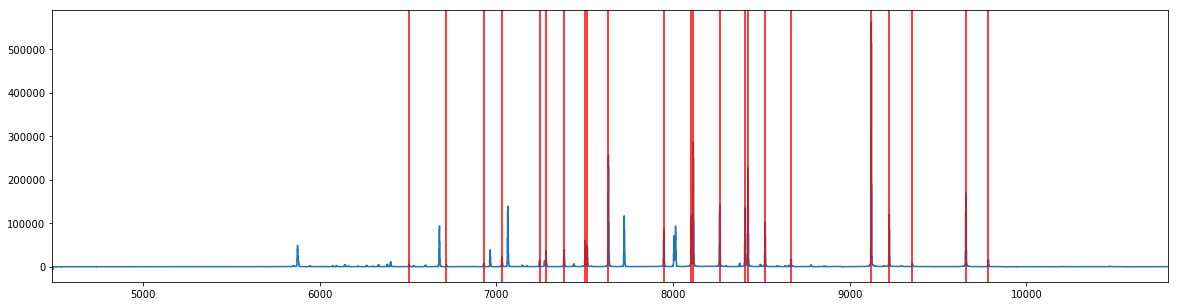

In [6]:
#creating a ds _ part three

ds_red = pipeline.goodness_of_matches(arcfiles_red10, guesses, all_side_files_red, atlasfiles_red, linelist_red, flatid);
#this is the final red side ds

# Creating a BLUE Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Blue side


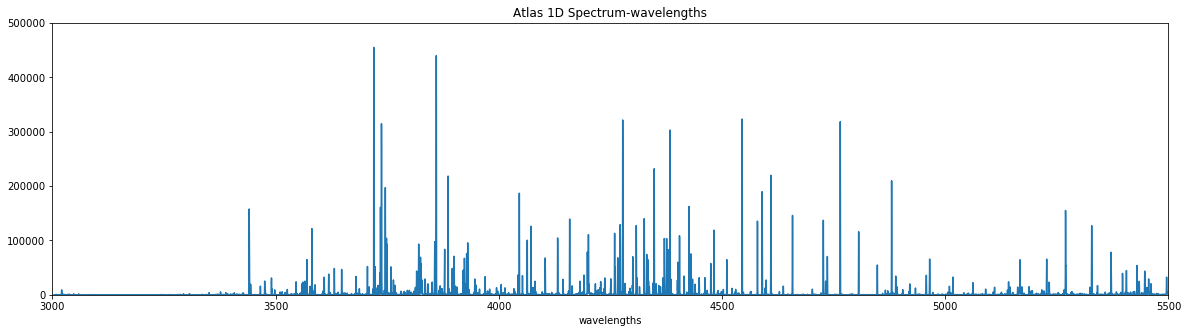

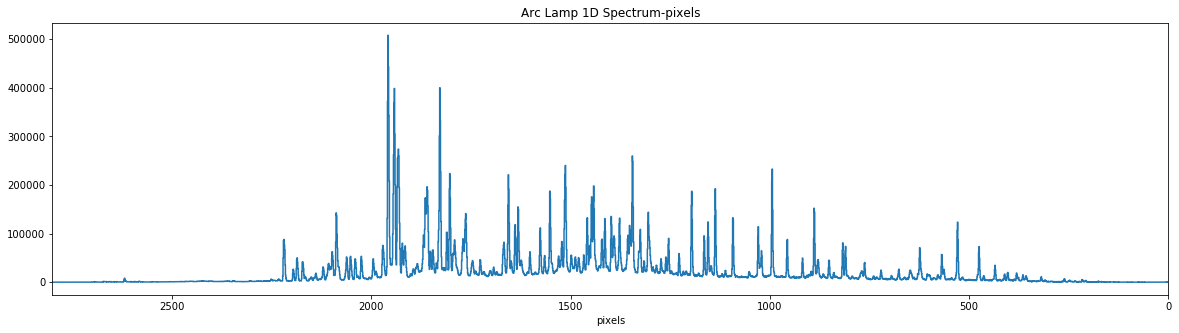

In [7]:
#creating a ds _ part one

#plotting arc lamp pixel data and atlas wl data to match lines in next cell
specset_blue = pipeline.dispersion(all_side_files_blue, atlasfiles_blue, arcfiles_blue10, linelist_blue,flatid)

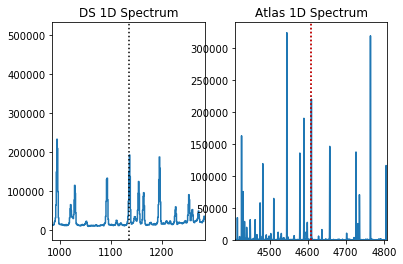

In [11]:
#creating a ds _ part two

#use above plots to enter guesses of matching lines
pipeline.guess_plot(1135,4609,specset_blue) #(arc-PIX-guess,atlas-WL-from-linelist)

#collect guesses here ~5 seems good
pixel_guesses = [1956,1827,993,1029,528]#badvals 1135
atlas_lines = [3719.9346, 3859.9114, 4764.8646, 4726.8683, 5269.5366] #badvals 4609.5673
guesses = list(zip(pixel_guesses, atlas_lines)) #must be tuples

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for blueside
chose guesses for blueside
Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 0.9283220677308877, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Guessed line's peak to base ratio is 1.1792408779758057, which is less than 5"
Failed to find line FeI at wl=3037.3887: "Guessed line's peak to base ratio is 2.3370690055694463, which is less than 5"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 2.7543769339564936, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.0635750414101492, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.0635750414101492, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 0.9566180332361156, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.1629140069854265, which

Found line ArII at wl=4033.8093
Clipped 0 lines
Failed to find line ArII at wl=4042.8937: "Tried to find peak at 1659.1828727561137 but it's in a valley, not a peak"
Found line ArI at wl=4044.4179
Clipped 0 lines
Found line FeI at wl=4045.813
Clipped 0 lines
Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 2.1286846002939197, which is less than 5"
Found line FeI at wl=4063.5939
Clipped 0 lines
Failed to find line ArII at wl=4103.9121: "Guessed line's peak to base ratio is 3.4445683200803465, which is less than 5"
Failed to find line FeI at wl=4118.5442: "Guessed line's peak to base ratio is 1.6978293675061544, which is less than 5"
Found line ArII at wl=4131.7235
Clipped 0 lines
Failed to find line FeI at wl=4143.8688: "Guessed line's peak to base ratio is 4.470555295410519, which is less than 5"
Found line ArI at wl=4158.5905
Clipped 0 lines
Failed to find line ArI at wl=4164.1795: "Guessed line's peak to base ratio is 1.2374832679638155, which is less t

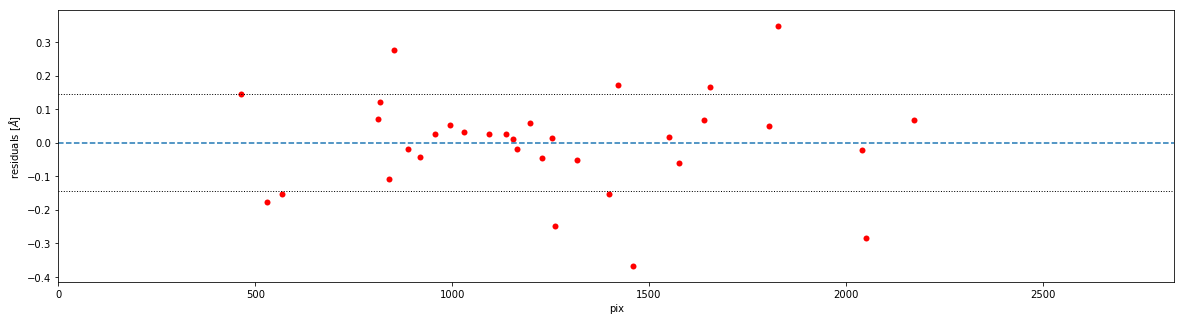

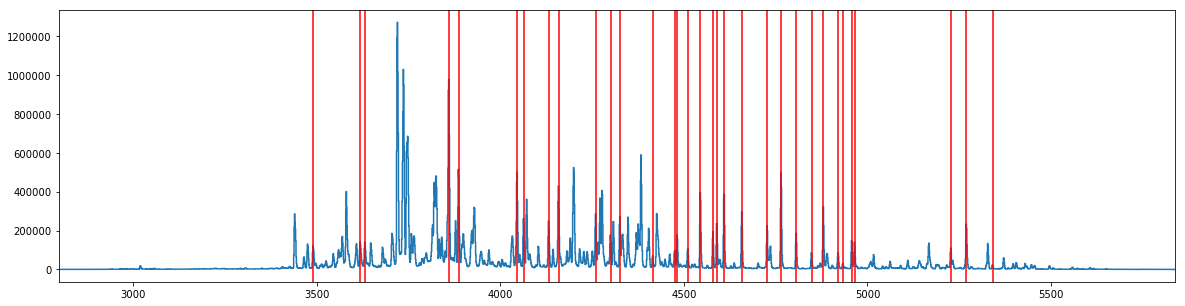

In [12]:
#creating a ds _ part three

ds_blue = pipeline.goodness_of_matches(arcfiles_blue10, guesses, all_side_files_blue, atlasfiles_blue, linelist_blue, flatid);
#this is the final blue side ds 

# Extracting 1D spectra (sky subtraction & stacking)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


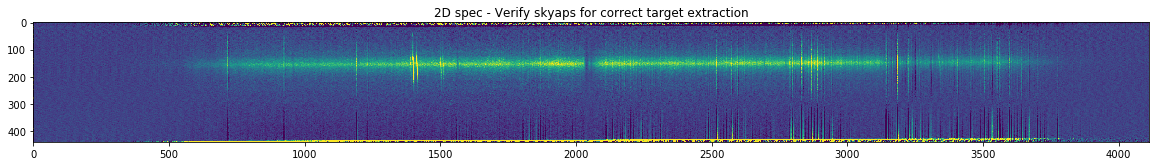

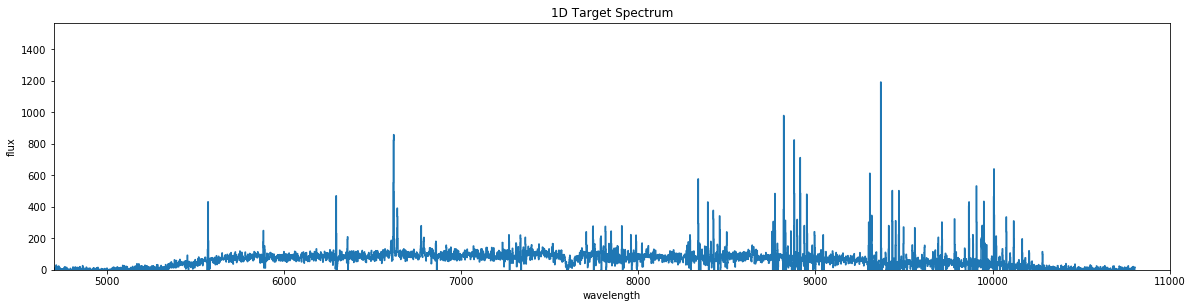

In [37]:
#RED side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_red=[(20,33),(265,320)]#spatial regions above & below target to estimate sky emissions
model_red='linear' #estimating sky line tilt
specaps_red = (215,250)#WHAT IS THIS AGAIN? target spatial region? area btwn skyaps??
#####################################################

#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_red, target_unc_red, target_comb_red = pipeline.sky_subtract(targetID, skyaps_red, ds_red, all_side_files_red, atlasfiles_red ,all_side_files_red, flatid, specaps_red, vmax, vmin, model_red)

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located
choose 2D spec for blueside
choose 1D target spec axis limits for blueside


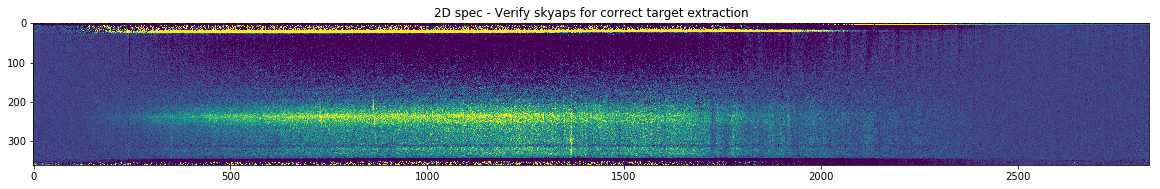

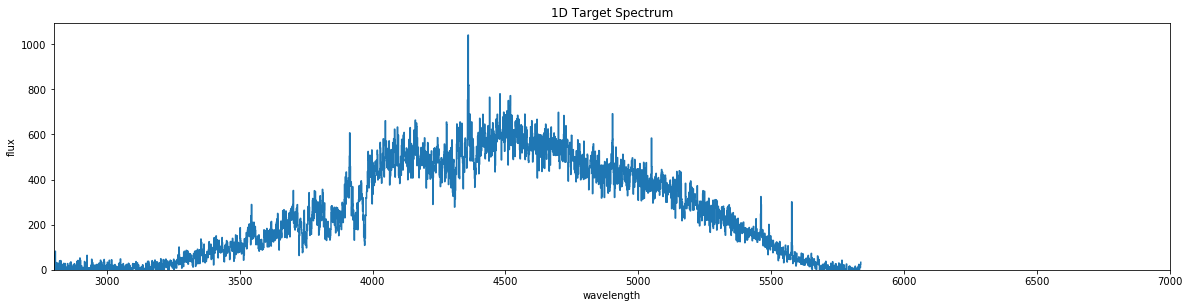

In [21]:
#BLUE side SPECTRUM

#define relevant pixel spatial regions
#####################################################
skyaps_blue = [(130,190),(318,350)]#spatial regions above & below target to estimate sky emissions
model_blue = 'linear'#('poly',2) #estimating sky line tilt
specaps_blue = (271,306)#target spatial region
#####################################################
#helps color scale of 2D
vmax = 40
vmin = -10

#subtracts sky lines & stacks target images to extract 1D
target_flux_blue, target_unc_blue, target_comb_blue = pipeline.sky_subtract(targetID, skyaps_blue, ds_blue, all_side_files_blue, atlasfiles_blue ,all_side_files_blue, flatid, specaps_blue, vmax, vmin, model_blue)

# Starting 2nd reduction technique for rot.curves

In [26]:
#isolates the sky-subtracted 2D spectrum

#choose best emission line side
##############################################
best_emission_comb = target_comb_red
best_emission_skyaps = skyaps_red
best_emission_model = model_red
##############################################

#sky-subtracting 2D
subimg2, comb2, fitmodels = sky_subtract2D(best_emission_comb, best_emission_skyaps, best_emission_model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

# Finding emission line CENTROIDs

FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)
flux data shape: (226, 4104)
NOTE 10 spectral PIXELS missing  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


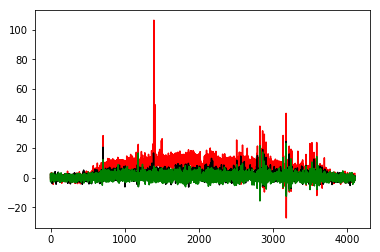

In [41]:
#PART ONE -----------------prep for centroiding

#first need to get target only 2D aka(1D spectrum for each spatial pixel row in the 2D target data)
############################################
target_aperature=(35,260) #target location
############################################
space_pix_correction = target_aperature[0]

flux_data=[] #to hold target only 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #list of rows to extract spec from
#np.shape(subimg2.data)#(440, 4114)


#extracting target spec from whole 2d spec
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects every row's spec within the target location
flux_data=np.array(flux_data)   
#need to find a way to sum over diff ranges of apslc 

#######################################################
#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #wont affect spatial pix values, only amount of flux but thats negligible
#######################################################

#just to visually confirm
plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

#conclusions
print("FLUX_DATA is the target's entire 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls)" )
print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE 10 spectral PIXELS missing ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

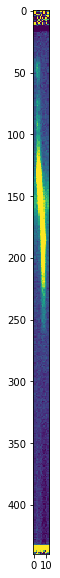

In [40]:
#PART TWO ----------------------determining best emission line pixel range

#using FULL ccd pixel range
################################################################
testingthis=subimg2.data[:,1396:1409] #[space,wl]for RED [wl,space]for BLUE
#conclusions
bestline_range_fullccd = (1396, 1409)
bestline_range_correction = (1386,1399) 
#################################################################

vmin=-10
vmax=45
plt.figure(figsize=(10,10))
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels

#### .........INSERT CONTINUUM SUBTRACTION HERE IF IT IS NEEDED.......

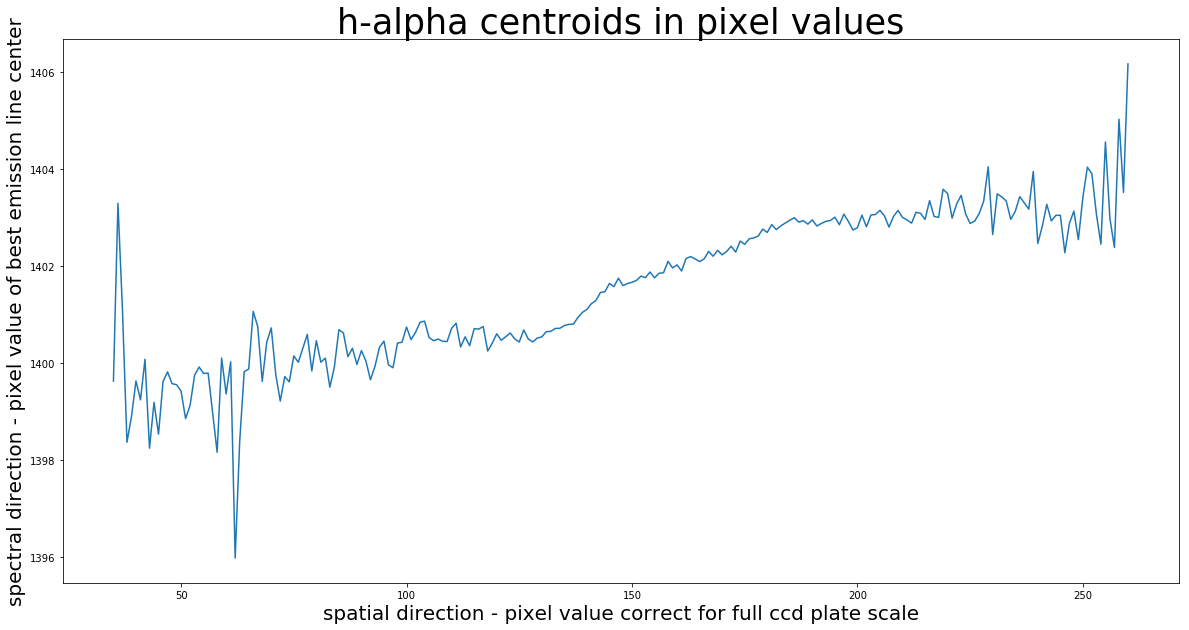

In [70]:
#PART THREE ------------------------------does the centroiding

#applies DS using full ccd pixel range 
#####################################################################
wl = np.array(ds_red.pixtowl(np.arange(len(subimg2.data[::][0]))))
#getting corresponding flux & wl values in best emission line region of 2D
wl_shorter2 = wl[1396:1409] #isolate wl around h-alpha using 'bestline_range_fullccd'
flux_data_short = flux_data[:,1386:1399] #use 'bestline_range_correction' range
#####################################################################


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]




#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in flux_data_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)#finds center(x,y) of best emission line for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all best emission line centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'][1][1])
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix = np.array(centroids_pix) #best emission line centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
gauss_stddev = np.array(stddev) #std of gaussians in pixels
gaussian_means = np.array(means) #gaussian peaks in pixels


#converting pixel values to be wrt full cdd
#wl axis
centroid_specpix_fullccd = centroids_pix + wl_pix_correction + bestline_range_correction[0]
gaussmax_specpix_fullccd = gaussian_means + stddev + wl_pix_correction + bestline_range_correction[0]
gaussmeans_specpix_fullccd = gaussian_means + wl_pix_correction + bestline_range_correction[0]
#space axis
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
###########################################################
plt.title('h-alpha centroids in pixel values',fontsize=35)
###########################################################

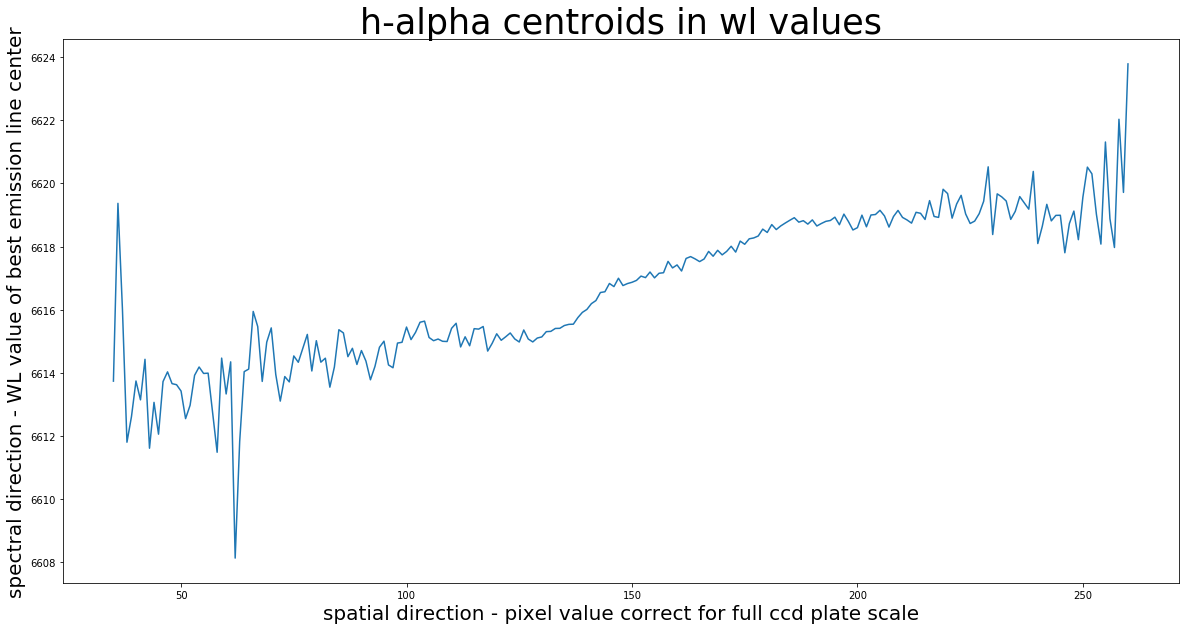

In [69]:
#converted centroids to wl to see how much of a shift there is

#applies ds
################################################################
wl_centroids = np.array(ds_red.pixtowl(centroid_specpix_fullccd))
#################################################################

#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - WL value of best emission line center',fontsize=20)
plt.plot(target_spacepix_fullccd,wl_centroids)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
##########################################################
plt.title('h-alpha centroids in wl values',fontsize=35)
##########################################################

# Getting Galaxy Spatial Core Pix Value
#### CORE along spatial axis via TWO SECTIONS (most accurate way)

shape of first section: (226, 50) matches shape of second section: (226, 50)
shape of first section 2d: (226, 1)
shape of second section 2d: (226, 1)
first section centroid x,y: 0.0 120.105929324
second section centroid x,y: 0.0 120.194353254
This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS 120.150141289
Pixel Value of core along spatial axis wrt full CCD size 155.150141289


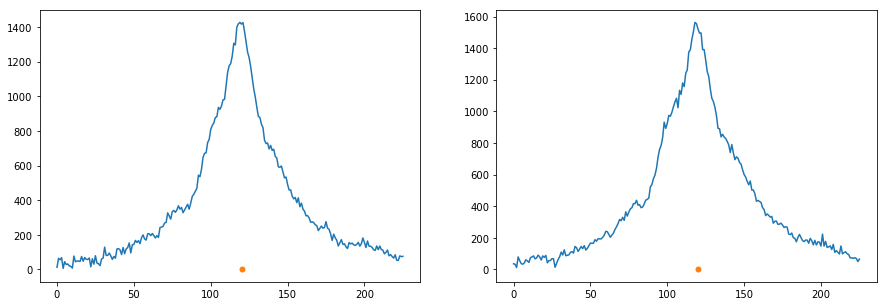

In [51]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
np.shape(flux_data)#(226,4104) #note that this is missing those wl's


#making arrays surrounding best emission line
################################################
upperha = 1399
lowerha = 1386
#################################################
width_sections = 50
upper_one = lowerha - 1 #distance to avoid line emission contaminating core determination
lower_one = upper_one - width_sections
lower_two = upperha + 1 #giving it some distance
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
x_first, y_first = centroid_com(first_section2d)
x_second, y_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE SPATIAL CORRECTIONS',core_avgcentroids)

#FULL CCD pixel value of core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)



# Spectral Core (aka Best Emission Line center wl)

In [53]:
#NOTE THAT THIS CELL USES GAUSSIAN VALUES.....IF CENTROIDS HAVE BETTER FIT (less likely) CHANGE IT

#robust way to clean data (to avoid bad g fits)
#################################################################
cleaned_gaussmeans = sigma_clip(gaussian_means, sigma=3)
################################################################
avg_of_gmeans = np.mean(cleaned_gaussmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
bestline_corewl_pix_fullccd = avg_of_gmeans + wl_pix_correction + bestline_range_correction[0]
print(bestline_corewl_pix_fullccd)

#applying ds to get pix to wl value
########################################################################
bestline_core_wl = ds_red.pixtowl(bestline_corewl_pix_fullccd)*u.angstrom
#########################################################################

print('Best emission line "core" wl (based on gaussian fits) is:',bestline_core_wl)

1401.21967879
Best emission line "core" wl (based on gaussian fits) is: 6616.185559826508 Angstrom


In [54]:
#if above core isnt great can try below with a zoomed in region based on centroid of bestline
''' 
#first reduce means array length using spatial core pixel as the "center" to zoom in on
endlim = int(core_avgcentroids + 1)
startlim = int(core_avgcentroids - 1)
zoomed_in_around_core_means = gaussian_means[startlim:endlim] 


#robust way to clean data
cleaned_zoomed_in_means = sigma_clip(zoomed_in_around_core_means, sigma=3)
avg_of_zoomed_in_gmeans = np.mean(cleaned_zoomed_in_means)
print("avg_of_zoomed_in_gmeans:",avg_of_zoomed_in_gmeans)

#correct to full ccd scale -used zoomed data but no correction for that b/c zoomed in spatial axis not spectral
bestline_corewl_pix_fullccd_zoomed_in_means = avg_of_zoomed_in_gmeans + wl_pix_correction + bestline_range_correction[0]

#pass thru ds
############################################################################
bestline_core_wl_fromzoomed_means = ds_red.pixtowl(bestline_corewl_pix_fullccd_zoomed_in_means)*u.angstrom
############################################################################

print(bestline_core_wl_fromzoomed_means)
'''

avg_of_zoomed_in_gmeans: 5.61627055847
6616.793976905975 Angstrom


# Converting Pixels --> kpc 

In [56]:
#centering around core first

#still in pixel space
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around best emission line

In [58]:
#actual converting for loop CENTROIDS pixels to kpc
#good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    blueplatescale = 0.389*u.arcsec/u.pixel
    dbsp_pix_equiv_red = u.pixel_scale(redplatescale)
    dbsp_pix_equiv_blue = u.pixel_scale(blueplatescale)
    r_in_pixel = i*u.pixel
    ################################################################
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv_red)
    distance = 37*u.Mpc # distance of object (host) from us
    ###############################################################
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    more_sections = r_in_kpc #/ (1*u.kpc)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)

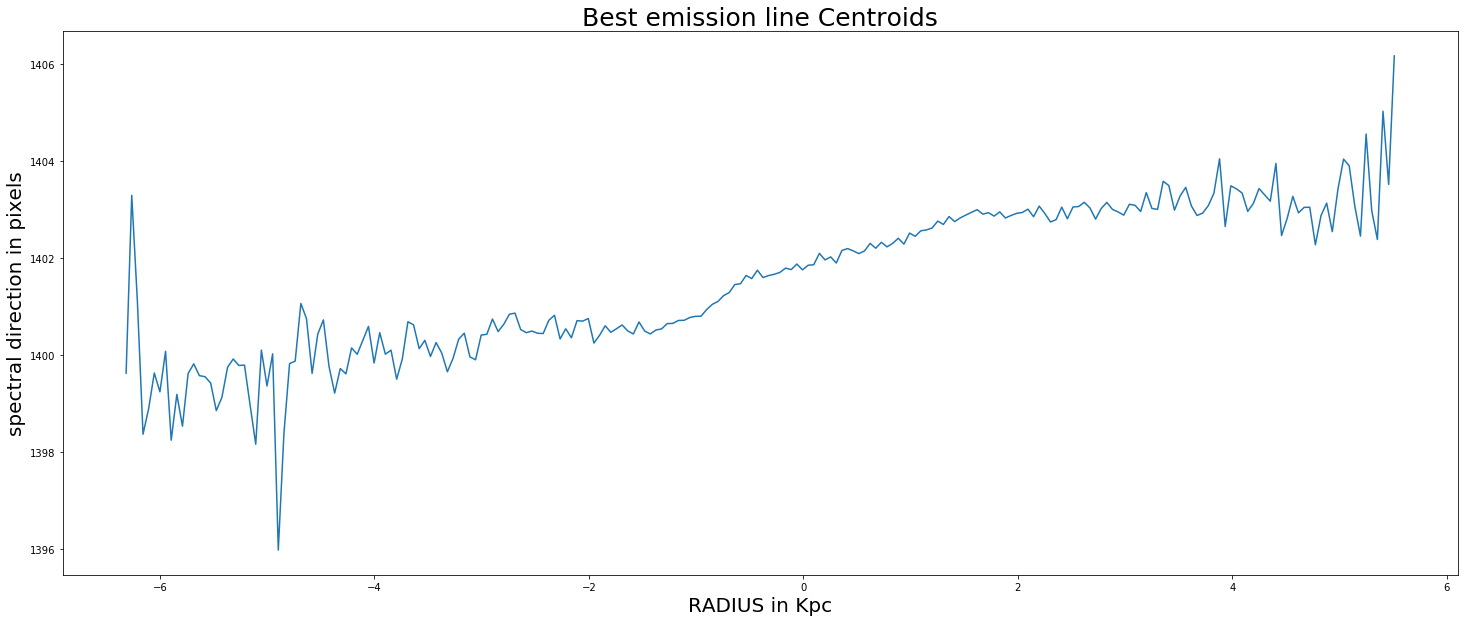

In [61]:
#CENTROID plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Centroids', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, centroid_specpix_fullccd)

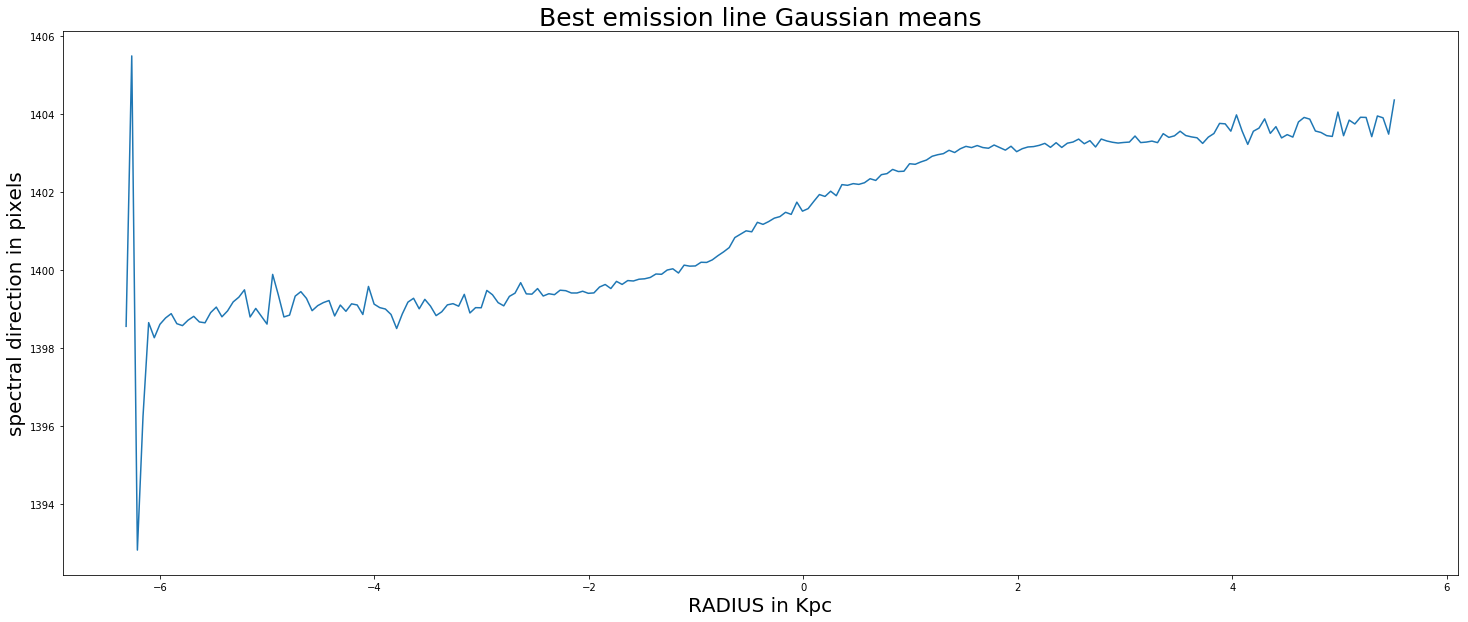

In [62]:
#GAUSSIAN MEANS plot with pix-wls & kpc

plt.figure(figsize=(25,10))
plt.title('Best emission line Gaussian means', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc, gaussmeans_specpix_fullccd)

# Converting pix ----> wl ----> velocity

In [64]:
#convert pix to wl via ds
###################################################################
centroids_wl = ds_red.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
gauss_means_wl = ds_red.pixtowl(gaussmeans_specpix_fullccd)*u.angstrom
core_wl_sections = ds_red.pixtowl(core_from_sections)*u.angstrom
####################################################################

In [65]:
#using redshift formula to get velocity

#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT yet relative to the core
##############################################################################
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
v_core = ((bestline_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
###############################################################################

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print("velocity of best emission line's spectral 'core':",v_core)

velocity of best emission line's spectral 'core': 2429472.7579605225 m / s


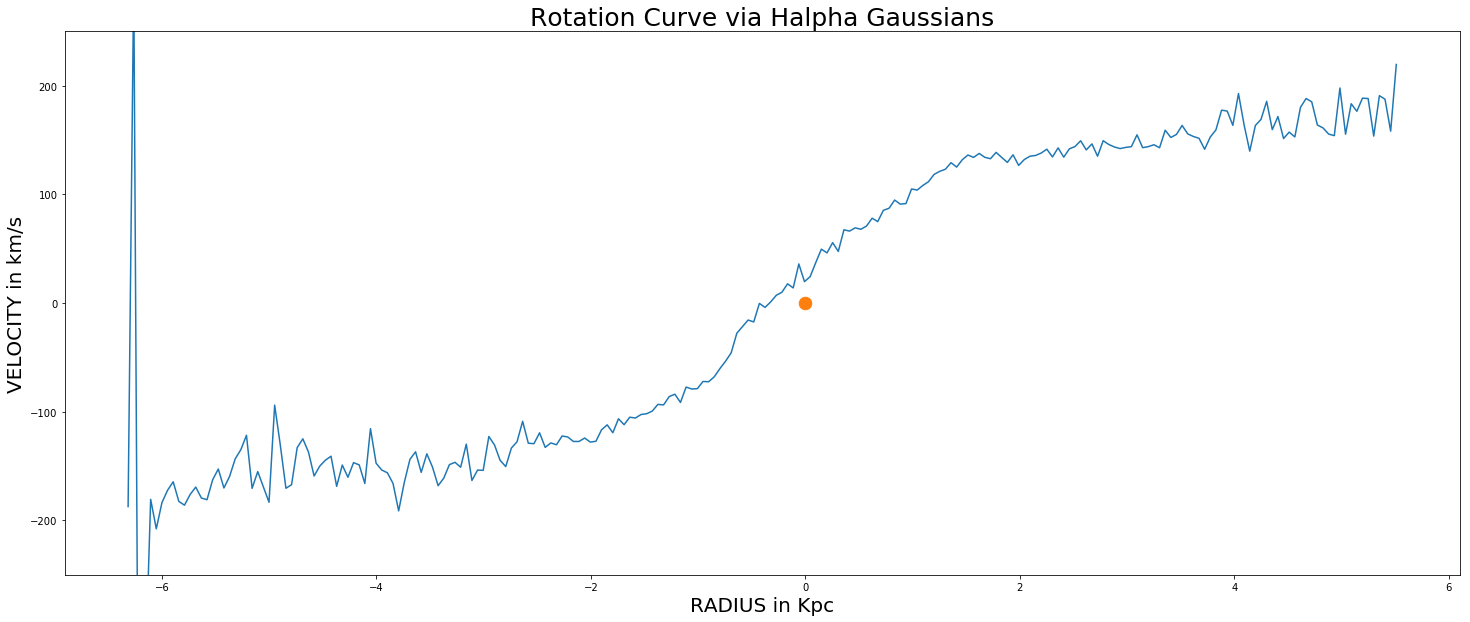

In [67]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

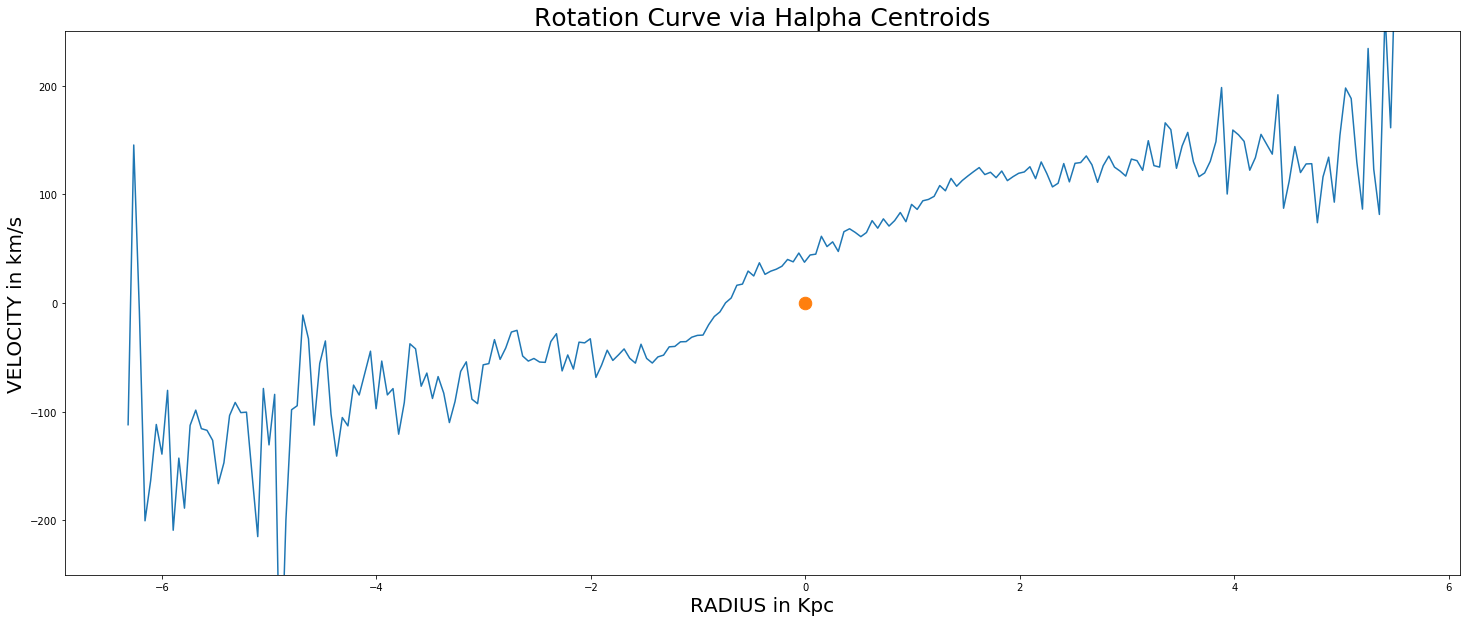

In [68]:
plt.figure(figsize=(25,10))
#######################################################
plt.title('Rotation Curve via Halpha Centroids', SIZE=25)
#######################################################
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Cvelocity)
plt.ylim(-250,250) #adjust as needed to center around zero
plt.plot(0,0,'.', markersize=25)

# Calculating ErrorBars

In [73]:
#using output from GAUSSIAN fit to determine error; tbd how to for CENTROIDS

#method to obtain sigma = subttract velocities of (mean+sigma) - mean = sigma 
sigma_gauss_pix = np.sqrt(np.abs(means_unc)) #taking sqrt of unc to get a true sigma
#correct to full ccd pix scale
means_Wsigma_fullccd = gaussian_means + sigma_gauss_pix + wl_pix_correction + bestline_range_correction[0]
#apply ds
means_max_wl = ds_red.pixtowl(means_Wsigma_fullccd)*u.angstrom


#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c #be sure to check all values ok (no inf)
#in converting pix2wl2vel section...already did same steps for means w/o sigma


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
#print(np.shape(v_unc))
#np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))#make sure its same length as y_axis_Gvelocity

(226,)
v_unc (226,)


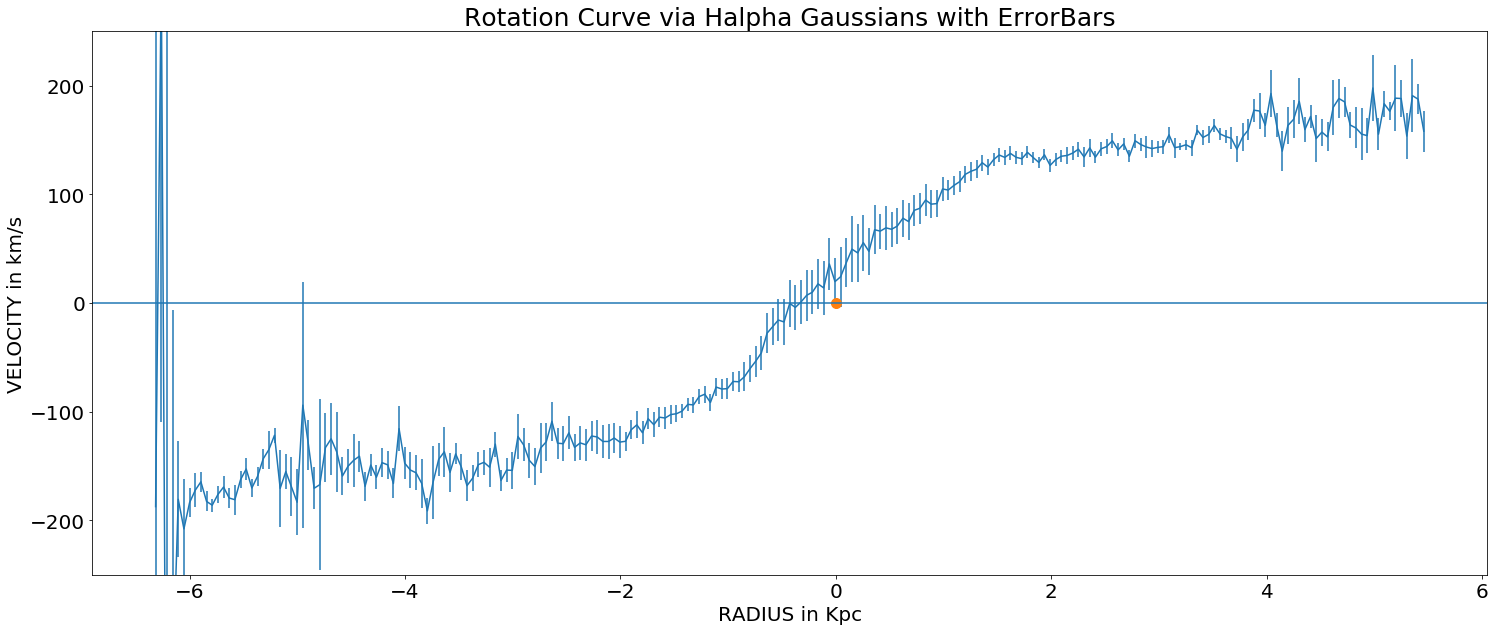

In [75]:
#rotation curve with gaussians with errorbars
plt.figure(figsize=(25,10))


arr = np.asarray #need to avoid setting array element as sequence
#had to chop last value b/c in sigma array = -inf
###############################################################################
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity[:-1]), yerr=arr(v_unc[:-1]))
###############################################################################
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)
plt.axhline(0)

# Mass Modeling

Model: eriksmodel
Inputs: ('r',)
Outputs: ('r',)
Model set size: 1
Parameters:
        alpha          beta         sigma          omega     
    ------------- ------------- -------------- --------------
    24.2680797444 27.8829040101 -95.7442564158 -9.20225261009


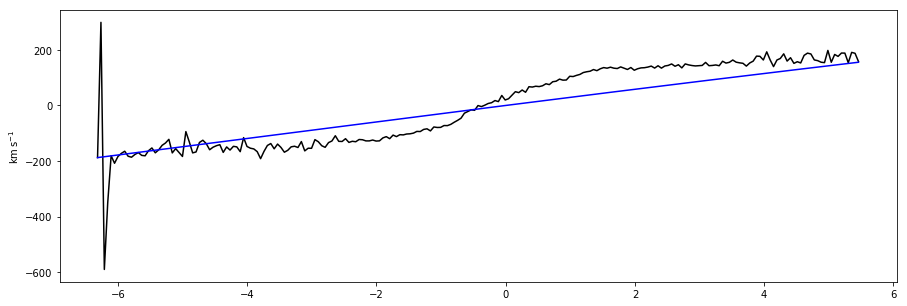

In [79]:
#eriks model eqt 5

@custom_model #very necessary line
def eriksmodel(r, alpha=.1, beta=.1, sigma=250, omega=.4):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)


#fit model to data
m_init = eriksmodel()
fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity[:-1]),weights=arr(v_unc[:-1]))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
########################################################################
plt.plot(distances_sections[:-1], y_axis_Gvelocity[:-1], color='k')
########################################################################
plt.plot(distances_sections[:-1], m(distances_sections[:-1]), color='b')
#plt.ylim(-230,200) #zooms to see data good, if fit is good
#plt.ylim(-1000,2000) #to see whole effect of param playing on fit line